In [1]:
import gmsh
import ufl
from dolfinx.io import gmshio
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
from dolfinx import mesh, fem
from dolfinx.io import XDMFFile
from dolfinx.fem import (Constant, Function, functionspace, dirichletbc, 
                        form, locate_dofs_geometrical)
from ufl import atan, pi, conditional
from dolfinx.fem.petsc import (assemble_matrix, assemble_vector, apply_lifting, 
                              create_vector, set_bc)
from dolfinx.geometry import BoundingBoxTree
from dolfinx.cpp.geometry import create_midpoint_tree
from basix.ufl import element
from ufl import (TestFunction, TrialFunction, div, dot, dx, inner, grad,
                 nabla_grad, lhs, rhs)

In [2]:
class BiharmonicDiscontinuousSolver:
    def __init__(self, n, a, epsilon=1e-6):
        self.comm = MPI.COMM_WORLD
        self.n = n
        self.a = a
        self.epsilon = epsilon
        self.setup_geometry()
        self.setup_function_spaces()
        
    def setup_geometry(self):
        import gmsh
        from dolfinx.io import gmshio
        
        gmsh.initialize()
        gmsh.model.add("circle")
        membrane = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
        gmsh.model.occ.synchronize()
        
        gdim = 2
        gmsh.model.addPhysicalGroup(gdim, [membrane], 1)
        
        gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 1.0/self.n)
        gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 1.0/self.n)
        gmsh.model.mesh.generate(gdim)
        
        gmsh_model_rank = 0
        self.domain, cell_markers, facet_markers = gmshio.model_to_mesh(
            gmsh.model, self.comm, gmsh_model_rank, gdim=gdim)
        
        gmsh.finalize()
    
    def setup_function_spaces(self):
        element_type = ("Lagrange", 1)
        self.V = fem.functionspace(self.domain, element_type)
        
        def on_boundary(x):
            return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)
        
        boundary_dofs = fem.locate_dofs_geometrical(self.V, on_boundary)
        self.bc = fem.dirichletbc(PETSc.ScalarType(0), boundary_dofs, self.V)

    def create_variational_form(self, u_prev):
        """Creates variational form for the biharmonic problem."""
        import ufl
        
        u = ufl.TrialFunction(self.V)
        v = ufl.TestFunction(self.V)
        
        # Biharmonic term
        # a = ufl.inner(ufl.grad(ufl.grad(u)), ufl.grad(ufl.grad(v))) * ufl.dx
        a = 0.1 * ufl.inner(ufl.grad(ufl.grad(u)), ufl.grad(ufl.grad(v))) * ufl.dx
        
        # Nonlinear term
        x = ufl.SpatialCoordinate(self.domain)
        h_reg = 0.5 * (1 + ufl.tanh((u_prev - self.a)/self.epsilon))
        L = h_reg * self.q(u_prev) * v * ufl.dx
        
        return a, L
    
    def q(self, u):
        """Nonlinear term q(u)."""
        # return u**3 - u
        return 10.0 * u - u**3
    
    def solve(self, max_iter=100, tol=1e-6):
        u_n = fem.Function(self.V)
        # u_n.x.array[:] = self.a/2
        x = ufl.SpatialCoordinate(self.domain)
        expr = fem.Expression(1.0 * ufl.sin(2*ufl.pi*x[0]) * ufl.sin(2*ufl.pi*x[1]), 
                     self.V.element.interpolation_points())
        u_n.interpolate(expr)
        
        solver = PETSc.KSP().create(self.comm)
        solver.setType(PETSc.KSP.Type.GMRES)
        pc = solver.getPC()
        pc.setType(PETSc.PC.Type.HYPRE)
        pc.setHYPREType("boomeramg")
        
        for i in range(max_iter):
            a, L = self.create_variational_form(u_n)
            A = assemble_matrix(form(a), bcs=[self.bc])  # Changed from bc_u to bc
            A.assemble()
            
            b = create_vector(form(L))
            assemble_vector(b, form(L))
            apply_lifting(b, [form(a)], [[self.bc]])  # Changed from bc_u to bc
            b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, 
                        mode=PETSc.ScatterMode.REVERSE)
            set_bc(b, [self.bc])  # Changed from bc_u to bc
            
            solver.setOperators(A)
            
            u = fem.Function(self.V)
            u_petsc = PETSc.Vec().createWithArray(u.x.array, comm=self.comm)
            solver.solve(b, u_petsc)
            u.x.array[:] = u_petsc.array[:]
            u.x.scatter_forward()
            
            error = np.max(np.abs(u.x.array - u_n.x.array))
            u_n.x.array[:] = u.x.array
            
            if error < tol:
                print(f"Convergence achieved in {i+1} iterations")
                break
                
            if i == max_iter - 1:
                print("Warning: Maximum iterations reached")
        
        return u_n
    
    def save_solution(self, u, filename="solution_biharmonic.xdmf"):
        """Guarda la solución en formato XDMF."""
        with XDMFFile(self.comm, filename, "w") as file:
            file.write_mesh(self.domain)
            u.name = "u"
            file.write_function(u)
            
    def plot_solution(self, u):
        """Visualizes the solution on circular domain."""
        import matplotlib.pyplot as plt
        import numpy as np
        from dolfinx.geometry import bb_tree, compute_collisions_points
        
        # Grid setup
        n = 100
        r = np.linspace(0, 1, n)
        theta = np.linspace(0, 2*np.pi, n)
        r_grid, theta_grid = np.meshgrid(r, theta)
        
        # Convert to Cartesian coordinates
        x_grid = r_grid * np.cos(theta_grid)
        y_grid = r_grid * np.sin(theta_grid)
        
        points_3d = np.zeros((n*n, 3))
        points_3d[:,0] = x_grid.ravel()
        points_3d[:,1] = y_grid.ravel()
        
        # Get cell collisions
        tree = bb_tree(self.domain, self.domain.topology.dim)
        collisions = compute_collisions_points(tree, points_3d)
        
        # Extract first collision for each point
        cell_indices = []
        for i in range(collisions.num_nodes):
            adjacency = collisions.links(i)
            cell_indices.append(adjacency[0] if len(adjacency) > 0 else -1)
        
        cell_indices = np.array(cell_indices)
        mask = cell_indices >= 0
        
        # Evaluate solution
        values = np.full(n*n, np.nan)
        if np.any(mask):
            values[mask] = u.eval(points_3d[mask], cell_indices[mask]).ravel()
        
        U = values.reshape((n, n))
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        c1 = ax1.contourf(x_grid, y_grid, U, levels=20, cmap='viridis')
        plt.colorbar(c1, ax=ax1, label='u(x,y)')
        ax1.set_title('Cartesian')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_aspect('equal')
        
        c2 = ax2.contourf(theta_grid, r_grid, U, levels=20, cmap='viridis')
        plt.colorbar(c2, ax=ax2, label='u(r,θ)')
        ax2.set_title('Polar')
        ax2.set_xlabel('θ')
        ax2.set_ylabel('r')
        
        plt.tight_layout()
        plt.show()

In [3]:
# Parámetros del problema
n = 50  # resolución de la malla
a = 0.5  # parámetro de discontinuidad

# Crear y resolver
solver = BiharmonicDiscontinuousSolver(n, a)
u = solver.solve()

# Guardar solución
solver.save_solution(u)
print("Solución encontrada y guardada exitosamente.")

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000156221s, CPU 5.8e-05s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.350018s, CPU 0.340339s)
Info    : 9342 nodes 18683 elements
Convergence achieved in 2 iterations
Solución encontrada y guardada exitosamente.


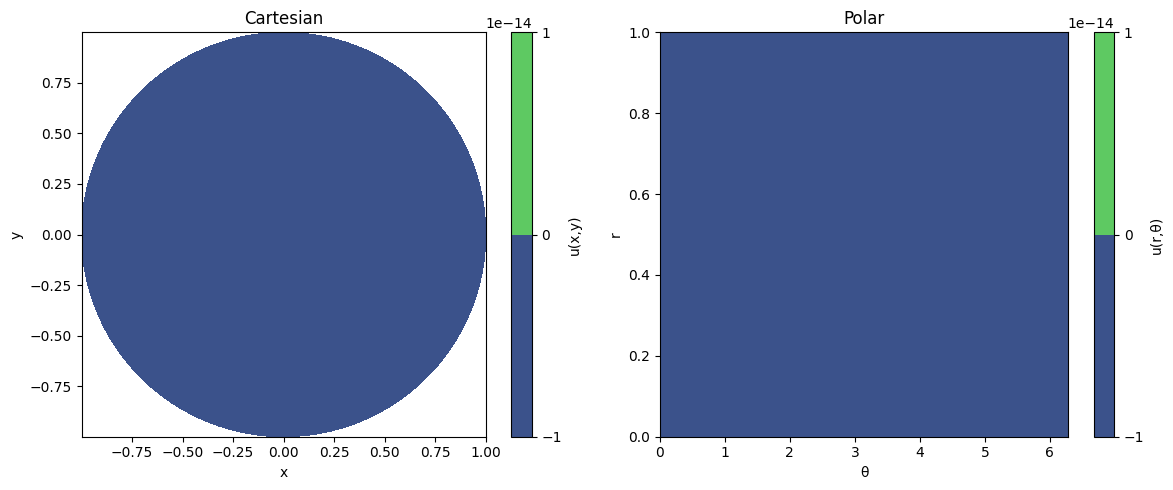

In [4]:
solver.plot_solution(u)